## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.core.debugger import set_trace
%matplotlib inline

In [2]:
def plot_images(original, result, output_path=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    f.tight_layout()

    ax1.set_title('Original Image', fontsize=15)
    ax2.set_title('Result Image', fontsize=15)
    
    ax1.imshow(original, cmap='gray')
    ax2.imshow(result, cmap='gray')
    
    if(output_path):
        plt.savefig(output_path, dpi=100)

In [65]:
def plot_image(img, output_path=None):
    f, ax1 = plt.subplots(1, 1, figsize=(20, 12))
    ax1.imshow(img, cmap='gray')
    
    if(output_path):
        plt.savefig(output_path, dpi=100)

In [4]:
def compute_camera_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return (objpoints, imgpoints)

## Apply a distortion correction to raw images

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    # Convert image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calibrate the camera based objpoints and imgpoints
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    # Undistort the image based on the calibration
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

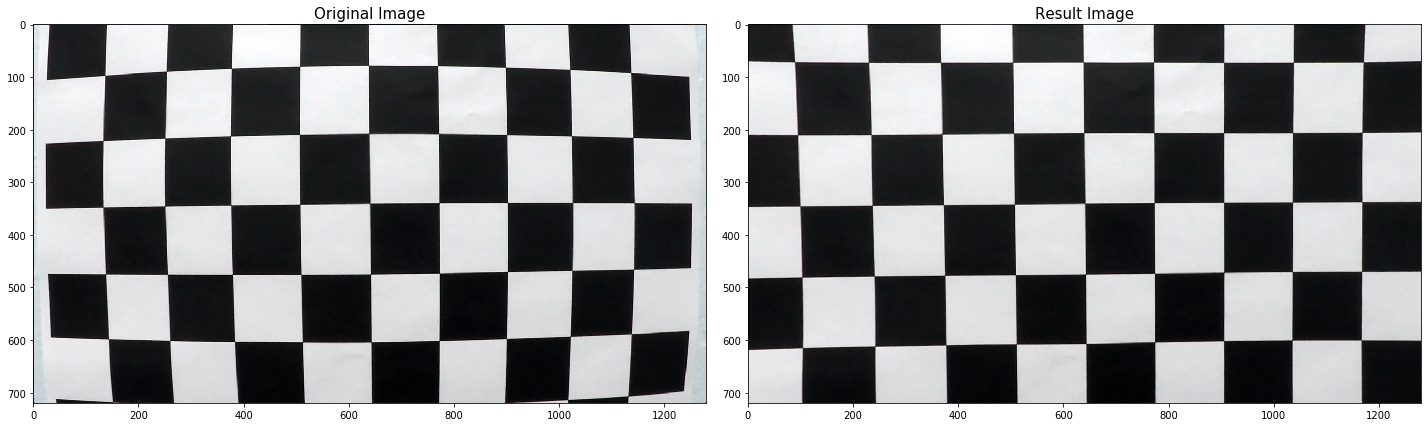

In [6]:
objpoints, imgpoints = compute_camera_calibration()

image = glob.glob('../camera_cal/calibration1.jpg')
image = cv2.imread(image[0])

undistort_img = cal_undistort(image, objpoints, imgpoints)

image = plot_images(image, undistort_img, "../output_images/undistort_output.png")

## Use color transforms, gradients, etc., to create a thresholded binary image
### Sobel Techniques

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [9]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

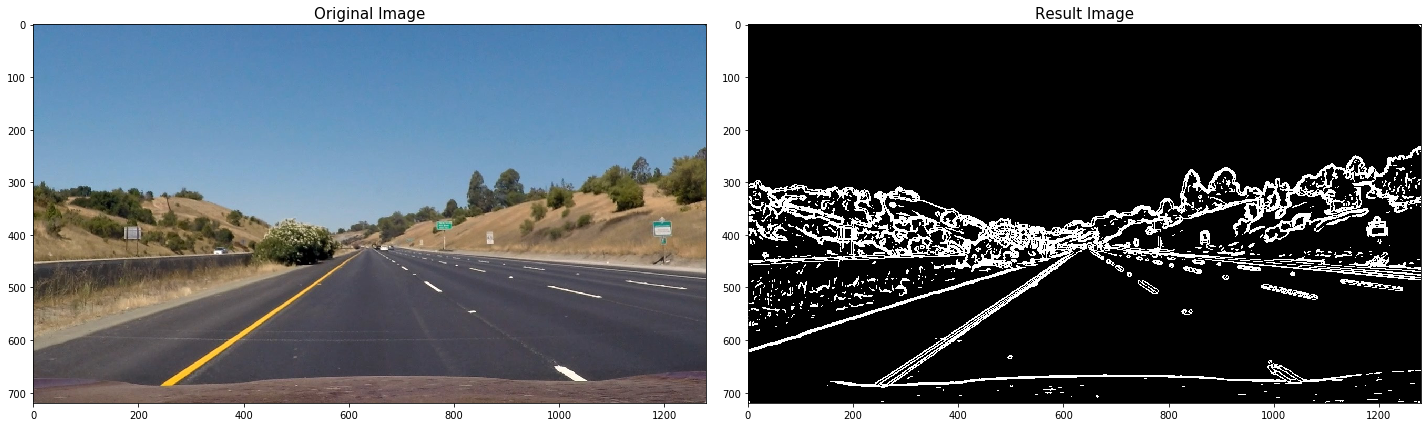

In [10]:
image = glob.glob('../test_images/straight_lines1.jpg')
image = mpimg.imread(image[0])

ksize = 15
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_thresh(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# combined[((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1)) | ((mag_binary == 1))] = 1

plot_images(image, combined, "../output_images/test1.jpg")

### HLS Technique

In [11]:
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Get the white line based on saturation channel with the threshold
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

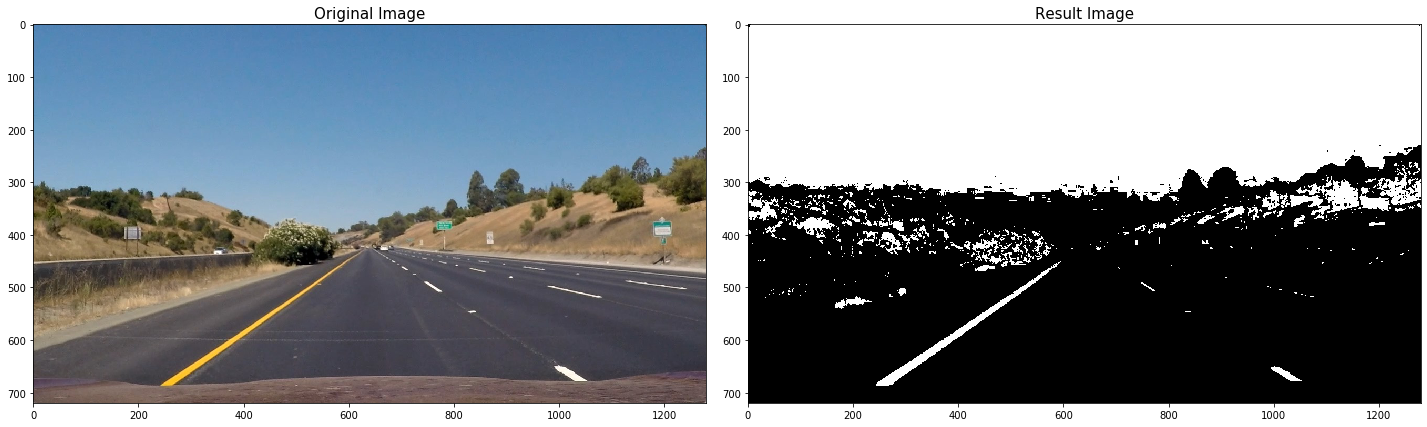

In [12]:
image = glob.glob('../test_images/straight_lines1.jpg')
image = mpimg.imread(image[0])

hls_binary = hls_select(image, thresh=(90, 255))
plot_images(image, hls_binary, "../output_images/binary_combo_example.jpg")

### Sobel and HLS Techniques Combined

In [49]:
def binary_image(img, sobel_kernel=3, thresh=(0,255)):
    # HLS
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > 90) & (s_channel <= 255)] = 1

    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(s_binary == 1) | (mag_binary == 1) ] = 1
    
    # Return the result
    return combined_binary

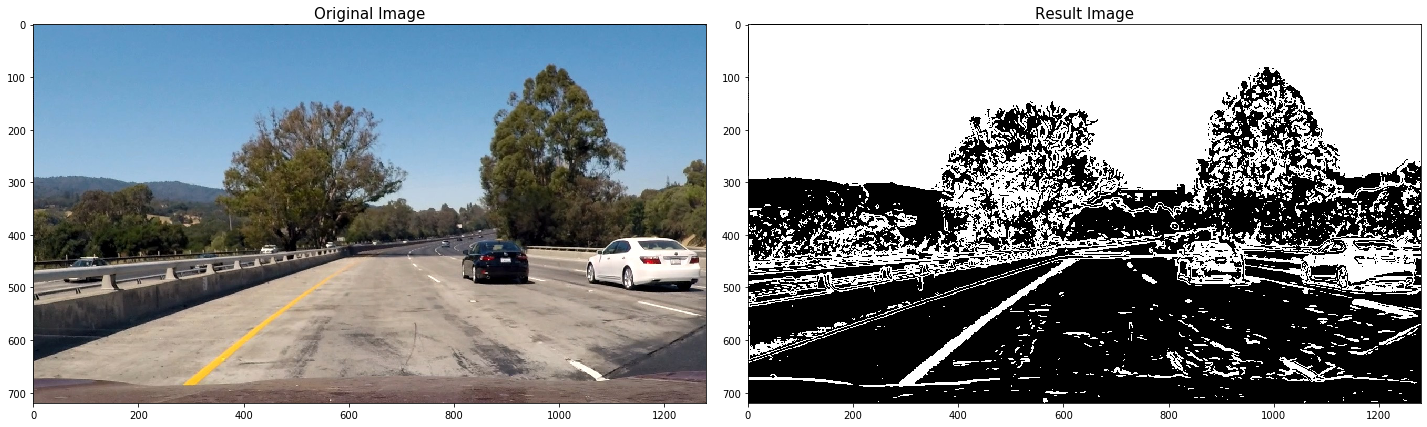

In [50]:
image = glob.glob('../test_images/straight_lines1.jpg')
image = glob.glob('../test_images/test1.jpg')
image = mpimg.imread(image[0])

ksize = 15
binary_output = binary_image(image, sobel_kernel=ksize, thresh=(30, 100))

plot_images(image, binary_output)

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [51]:
# src = np.float32(
#     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#     [((img_size[0] / 6) - 10), img_size[1]],
#     [(img_size[0] * 5 / 6) + 60, img_size[1]],
#     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
# dst = np.float32(
#     [[(img_size[0] / 4), 0],
#     [(img_size[0] / 4), img_size[1]],
#     [(img_size[0] * 3 / 4), img_size[1]],
#     [(img_size[0] * 3 / 4), 0]])

In [29]:
def warp_image(undistort_img):
#     gray = cv2.cvtColor(undistort_img, cv2.COLOR_RGB2GRAY)
    img_size = (undistort_img.shape[1], undistort_img.shape[0])
    src = np.float32(
                    [[590, 450],
                     [685, 450],
                     [230, 700],
                     [1070, 700]])
    
    dest = np.float32(
                    [[400, 5],
                     [1000, 5],
                     [400, 700],
                     [1000, 700]])
    
    M = cv2.getPerspectiveTransform(src, dest)
    
    warped = cv2.warpPerspective(undistort_img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

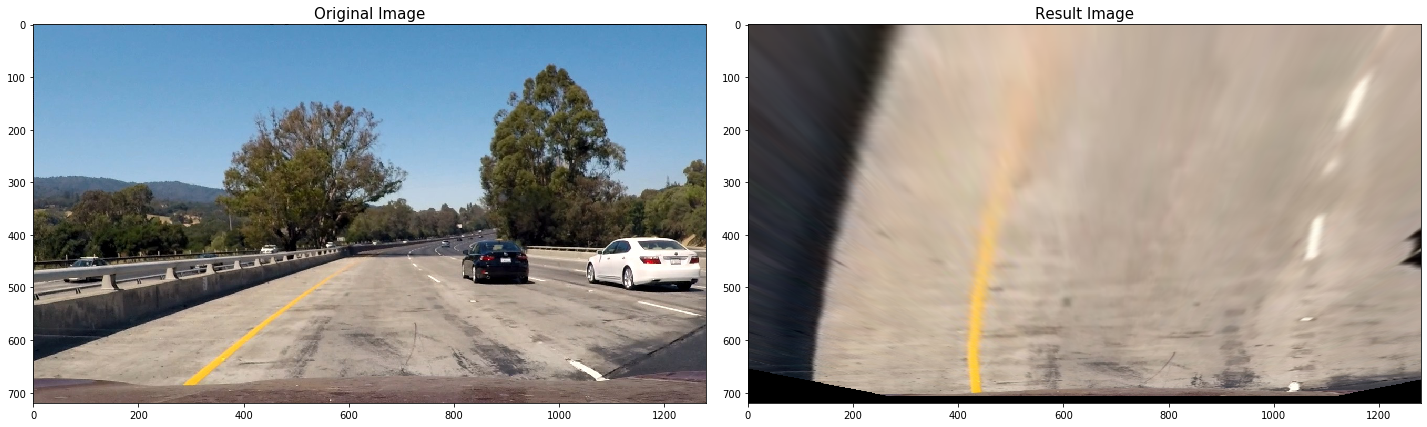

In [56]:
objpoints, imgpoints = compute_camera_calibration()

# image = glob.glob('../test_images/straight_lines1.jpg')
image = glob.glob('../test_images/test1.jpg')
# image = cv2.imread(image[0])
image = mpimg.imread(image[0])

undistort_img = cal_undistort(image, objpoints, imgpoints)

binary_output = binary_image(undistort_img, sobel_kernel=ksize, thresh=(30, 100))

binary_warped = warp_image(undistort_img)

# plot_image(undistort_img)
# plt.plot(590, 450, '.', color='red')
# plt.plot(685, 450, '.', color='red')
# plt.plot(230, 700, '.', color='red')
# plt.plot(1070, 700, '.', color='red')

# plt.plot(400, 5, '.', color='green')
# plt.plot(1000, 5, '.', color='green')
# plt.plot(400, 700, '.', color='green')
# plt.plot(1000, 700, '.', color='green')

plot_images(image, binary_warped, "../output_images/warped_straight_lines.jpg")

## Detect lane pixels and fit to find the lane boundary.

In [57]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [71]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fitx, right_fitx, out_img

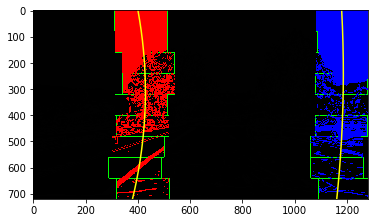

In [73]:
ploty, left_fitx, right_fitx, out_img = fit_polynomial(binary_output)

plt.imshow(out_img)
plt.savefig("../output_images/fit_poly.jpg", dpi=100)
# plot_image(out_img, "../output_images/fit_poly.jpg")

## Determine the curvature of the lane and vehicle position with respect to center.

In [37]:
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [38]:
def center_offset(binary_warped):
    car_center = binary_warped.shape[1]//2
    
    y = binary_warped.shape[0]//2

    xm_per_pix = 3.7/700
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    left = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    
    lane_center = (right - left)/2 + left
    
    offset = lane_center - car_center
    offset = (np.abs(car_center) - np.abs(lane_center)) * xm_per_pix
    
    return offset
    
    
    

In [40]:
left_curverad, right_curverad = measure_curvature_real(binary_output)
print(left_curverad, right_curverad)

15389.592002186342 2565.361303229935


In [41]:
center_offset(binary_output)

0.41193848250815046

## Warp the detected lane boundaries back onto the original image.

In [42]:
def unwarp_image(img):
#     gray = cv2.cvtColor(undistort_img, cv2.COLOR_RGB2GRAY)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
                    [[590, 450],
                     [685, 450],
                     [230, 700],
                     [1070, 700]])
    
    dest = np.float32(
                    [[400, 5],
                     [1000, 5],
                     [400, 700],
                     [1000, 700]])
    
    M = cv2.getPerspectiveTransform(dest, src)
    
    unwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return unwarped

In [43]:
def draw_detection(ploty, left_fitx, right_fitx, out_img, binary_warped):
    zero = np.zeros_like(binary_warped).astype(np.uint8)
    output = np.dstack((zero, zero, zero))

    left = np.array([np.column_stack([left_fitx, ploty])])
    right = np.array([np.flipud(np.column_stack([right_fitx, ploty]))])
    all_pts = np.hstack((left, right))

    cv2.fillPoly(output, np.int_([all_pts]), (0,255, 0))
    
#     cv2.polylines(output, np.int_([left]), False, (255, 0, 0), thickness=50)
#     cv2.polylines(output, np.int_([right]), False, (0, 0, 255), thickness=50)

    return output

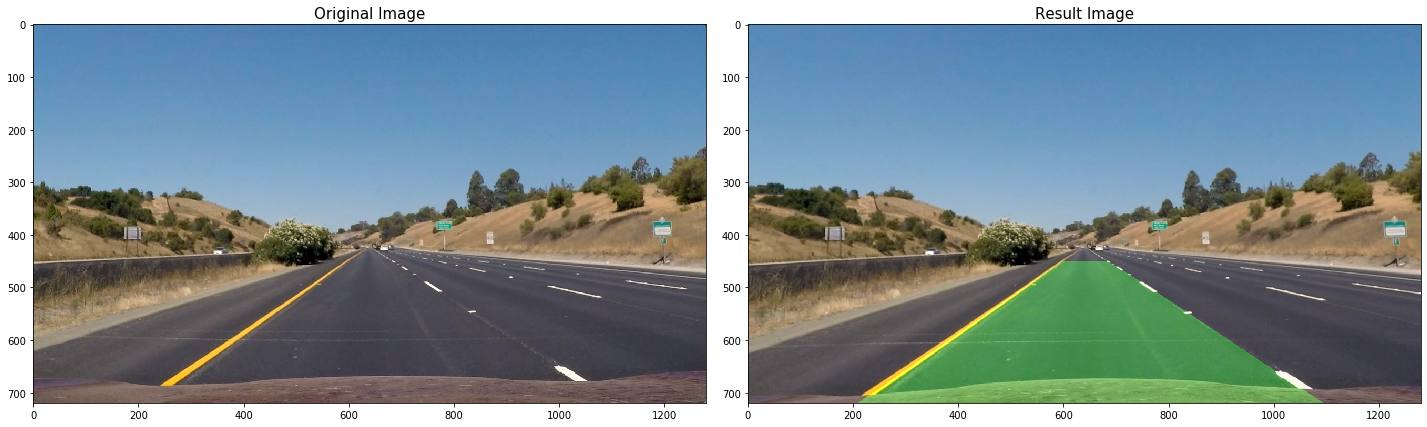

In [44]:
objpoints, imgpoints = compute_camera_calibration()

image = glob.glob('../test_images/straight_lines1.jpg')
# image = glob.glob('../test_images/test6.jpg')
image = mpimg.imread(image[0])

undistort_img = cal_undistort(image, objpoints, imgpoints)
    
ksize = 15
binary_output = binary_image(undistort_img, sobel_kernel=ksize, thresh=(30, 100))

binary_warped = warp_image(binary_output)

ploty, left_fitx, right_fitx, out_img = fit_polynomial(binary_warped)

draw_output = draw_detection(ploty, left_fitx, right_fitx, out_img, binary_warped)

unwarped = unwarp_image(draw_output)
result = cv2.addWeighted(undistort_img, 1, unwarped, 0.3, 0)

plot_images(image, result, "../output_images/color_fit_lines.jpg")

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [45]:
def pipeline(image):
    undistort_img = cal_undistort(image, objpoints, imgpoints)
    
    ksize = 15
    binary_output = binary_image(undistort_img, sobel_kernel=ksize, thresh=(30, 100))

    binary_warped = warp_image(binary_output)
    
    ploty, left_fitx, right_fitx, out_img = fit_polynomial(binary_warped)
    
    draw_output = draw_detection(ploty, left_fitx, right_fitx, out_img, binary_warped)
    
    unwarped = unwarp_image(draw_output)
    
    left_curverad, right_curverad = measure_curvature_real(binary_warped)
    
    offset = center_offset(binary_warped)

    result = cv2.addWeighted(undistort_img, 1, unwarped, 0.3, 0)

    result = cv2.putText(result, 'Radius of Curvature: ' + str((left_curverad+right_curverad)/2) + '(m)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2, cv2.LINE_AA) 
    
    if(offset < 0):
        result = cv2.putText(result, 'Vehicle is ' + str(abs(offset)) + '(m) left of center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2, cv2.LINE_AA) 
    else:
        result = cv2.putText(result, 'Vehicle is ' + str(abs(offset)) + '(m) right of center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2, cv2.LINE_AA) 
    
#     plot_images(image, result, "../output_images/example_output.jpg")
    return result

objpoints, imgpoints = compute_camera_calibration()

image = glob.glob('../test_images/straight_lines1.jpg')
# image = glob.glob('../test_images/test6.jpg')
image = mpimg.imread(image[0])

pipeline(image)    

array([[[ 83, 137, 184],
        [ 84, 138, 185],
        [ 84, 138, 185],
        ...,
        [ 73, 131, 179],
        [ 74, 131, 179],
        [ 74, 132, 180]],

       [[ 84, 137, 184],
        [ 84, 138, 185],
        [ 85, 139, 186],
        ...,
        [ 73, 131, 179],
        [ 74, 132, 180],
        [ 74, 132, 180]],

       [[ 84, 136, 184],
        [ 85, 137, 185],
        [ 86, 138, 186],
        ...,
        [ 73, 131, 178],
        [ 73, 131, 178],
        [ 73, 131, 178]],

       ...,

       [[ 96,  84,  98],
        [ 96,  84,  98],
        [ 96,  84,  98],
        ...,
        [118,  97,  92],
        [116,  95,  90],
        [115,  94,  89]],

       [[ 97,  85,  99],
        [ 96,  84,  97],
        [ 96,  84,  96],
        ...,
        [117,  96,  91],
        [116,  95,  90],
        [115,  94,  89]],

       [[100,  87,  99],
        [ 99,  87,  98],
        [ 99,  87,  97],
        ...,
        [117,  97,  95],
        [118,  98,  95],
        [117,  96,  93]]

## Process Video

In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [47]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    
    return result

In [48]:
white_output = '../output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('../project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../output_images/project_video.mp4.
Moviepy - Writing video ../output_images/project_video.mp4



Moviepy - Done !
Moviepy - video ready ../output_images/project_video.mp4
CPU times: user 15min 33s, sys: 39.6 s, total: 16min 12s
Wall time: 16min 19s
